In [101]:
import numpy as np
import matplotlib.pyplot as plt


configuramos los parametros de la simulación

In [70]:
N = 1000
fs = 1000.0  # frecuencia de muestreo (Hz)
ts = 1 / fs  # tiempo de muestreo
df = fs / N  # resolución espectral

R = 200 # realizaciones, cantidad de experimentos


In [102]:
def señal_experimental(A, omega_zero, N, fs, snr, R):
    ts = 1 / fs
    tt = np.linspace(0, (N - 1) * ts, N)
    sig_pow = (A**2) / 2

    noise_pow = sig_pow / 10**(snr/20)
    n = np.random.normal(0,noise_pow)
    fr = np.random.uniform(low=-0.5, high=0.5, size=R)

    omega_one = (omega_zero + fr) * df

    x = np.array([A * np.sin(2 * np.pi * o1 * tt) + n for o1 in omega_one])
    x = np.array(x).transpose()
    return x

In [144]:
s_10db = señal_experimental(A=2, omega_zero=N/4, N=N, fs=fs, snr=10, R=R)
s_3db = señal_experimental(A=2, omega_zero=N/4, N=N, fs=fs, snr=3, R=R)


En el siguiente grafico podemos observar como la energía de nuestra señal se desparrama en el espectro en vez de estar concentrada como una delta, producto de que la frecuencia de nuestra señal (debido a que esta es una variable estocastica) no es multiplo entero de la densidad espectral, por lo cual la energía de la delta se reparte en los bins adyacentes.

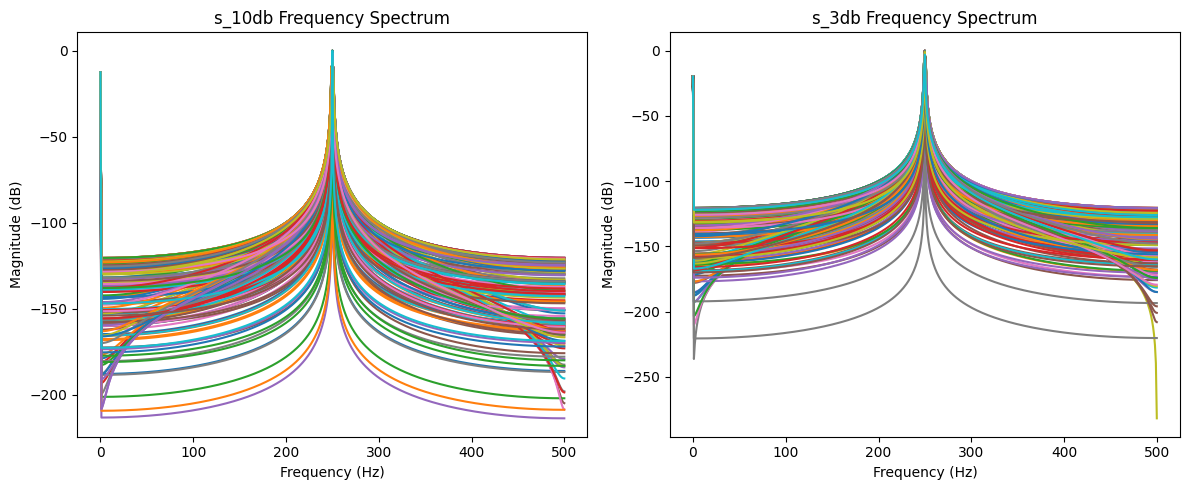

In [ ]:
ff = np.linspace(0, (N - 1) * df, N)

ft_10db = (1 / N) * np.fft.fft(s_10db, axis=0)
ft_3db = (1 / N) * np.fft.fft(s_3db, axis=0)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

axs[0].plot(
    ff[ff <= fs / 2],
    20 * np.log(np.abs(ft_10db[ff <= fs / 2, :])),
)
axs[0].set_title('s_10db Frequency Spectrum')
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Magnitude (dB)')

axs[1].plot(
    ff[ff <= fs / 2],
    20 * np.log(np.abs(ft_3db[ff <= fs / 2, :])),
)
axs[1].set_title('s_3db Frequency Spectrum')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Magnitude (dB)')

plt.tight_layout()

plt.show()

Definimos el estimador $\hat{a}_1$ como el valor medio de las $R$ (realizaciones) muestras $X(N/4)$ (mitad de banda digital) de la DFT de la señal medida.

$$
\hat{a}_{10} = \left| X\left(\frac{N}{4}\right) \right|_{\text{promedio}}
$$

El error relativo porcentual del estimador respecto a la potencia esperada de la señal $\frac{A^2}{2}$ se define como:

$$
\text{Error de } \hat{a}_{10} = \left( \frac{\left|\frac{A^2}{2} - \hat{a}_{10}\right|}{\frac{A^2}{2}} \right) \times 100
$$

Este estimador surge de fijar nuestro modelo de señal como una senoidal de frecuencia media $N/4$, por lo que esperamos ver a esta frecuencia $\frac{1}{2}$ de la potencia total de la señal, calculada como $\frac{A^2}{2}$.

In [171]:
def a_10_hat_estimator_with_error(signal, N, c=1):
    ft = (1 / N) * np.fft.fft(signal, axis=0)
    sig_pow = signal.var() / 2
    a10_hat = abs(ft[int(N/4), :])
    a10_hat_mean = c * a10_hat.mean()
    a10_hat_error = (abs(sig_pow - a10_hat_mean)/(sig_pow)) * 100
    return a10_hat, a10_hat_mean, a10_hat_error

In [159]:

a10_hat_10db, a10_hat_mean_10db, a10_hat_error_10db = a_10_hat_estimator_with_error(s_10db, N)
a10_hat_3db, a10_hat_mean_3db, a10_hat_error_3db = a_10_hat_estimator_with_error(s_3db, N)

In [160]:
from IPython.display import display, Markdown

# Crear texto en Markdown para s_10db y s_3db
markdown_text = f"""
### Resultados para $s_{{10dB}}$

El valor calculado del estimador $\\hat{{a}}_{{10}}$ es:

$$
\\hat{{a}}_{{10}} = {a10_hat_mean_10db:.2f}
$$

El error relativo porcentual del estimador respecto a la potencia esperada de la señal $\\frac{{A^2}}{{2}}$ es:

$$
\\text{{Error de }} \\hat{{a}}_{{10}} = {a10_hat_error_10db:.2f} \\, \\%
$$

### Resultados para $s_{{3dB}}$

El valor calculado del estimador $\\hat{{a}}_{{10}}$ es:

$$
\\hat{{a}}_{{10}} = {a10_hat_mean_3db:.2f}
$$

El error relativo porcentual del estimador respecto a la potencia esperada de la señal $\\frac{{A^2}}{{2}}$ es:

$$
\\text{{Error de }} \\hat{{a}}_{{10}} = {a10_hat_error_3db:.2f} \\, \\%
$$
"""

# Mostrar el Markdown con las variables
display(Markdown(markdown_text))


### Resultados para $s_{10dB}$

El valor calculado del estimador $\hat{a}_{10}$ es:

$$
\hat{a}_{10} = 0.87
$$

El error relativo porcentual del estimador respecto a la potencia esperada de la señal $\frac{A^2}{2}$ es:

$$
\text{Error de } \hat{a}_{10} = 13.02 \, \%
$$

### Resultados para $s_{3dB}$

El valor calculado del estimador $\hat{a}_{10}$ es:

$$
\hat{a}_{10} = 0.86
$$

El error relativo porcentual del estimador respecto a la potencia esperada de la señal $\frac{A^2}{2}$ es:

$$
\text{Error de } \hat{a}_{10} = 13.54 \, \%
$$


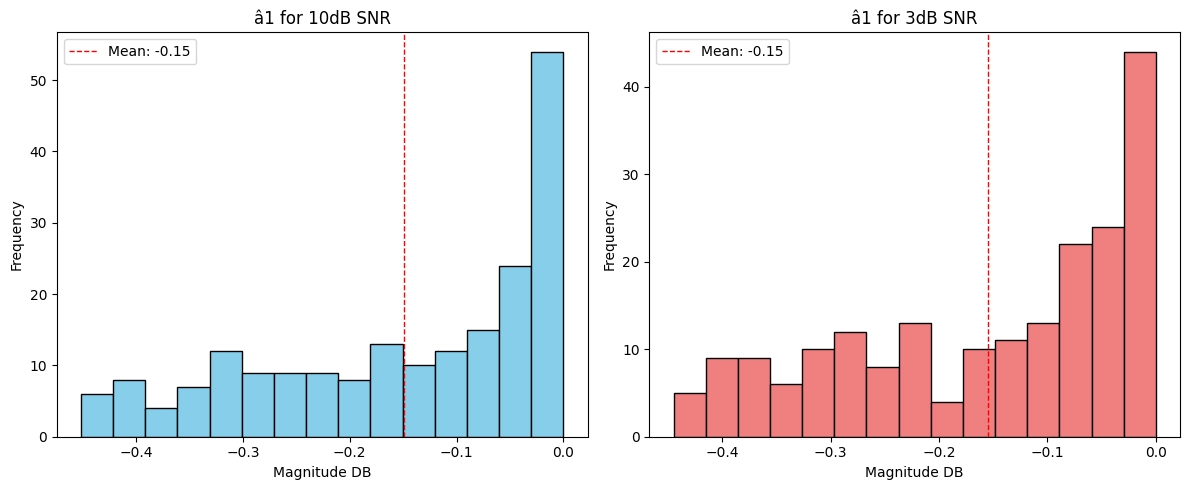

In [164]:
import matplotlib.pyplot as plt
import numpy as np

# Magnitudes for 10dB and 3dB signals
magnitude_10db = np.log(np.abs(a10_hat_10db))
magnitude_3db = np.log(np.abs(a10_hat_3db))

# Calculate statistics for both
mean_10db = np.mean(magnitude_10db)

mean_3db = np.mean(magnitude_3db)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot for 10dB
axs[0].hist(magnitude_10db, bins=15, color='skyblue', edgecolor='black')
axs[0].axvline(mean_10db, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_10db:.2f}')
axs[0].set_title('â1 for 10dB SNR')
axs[0].set_xlabel('Magnitude DB')
axs[0].set_ylabel('Frequency')
axs[0].legend()

# Plot for 3dB
axs[1].hist(magnitude_3db, bins=15, color='lightcoral', edgecolor='black')
axs[1].axvline(mean_3db, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_3db:.2f}')
axs[1].set_title('â1 for 3dB SNR')
axs[1].set_xlabel('Magnitude DB')
axs[1].set_ylabel('Frequency')
axs[1].legend()

plt.tight_layout()
plt.show()

### Calibración del estimador
En este paso vamos a obtener un factor de corrección c para mejorar la precisión de nuestro estimador.

$$
\hat{a}_{10} = C\left| X\left(\frac{N}{4}\right) \right|_{\text{promedio}}
$$


Como estamos modelizando la señal como una senoidal de amplitud $A$, podemos obtener $c$ como:

$$
c = \frac{P}{\hat{a}_{10}}
$$

In [169]:
c = (s_10db.var()/2) / a10_hat_mean_10db


1.149648250760629

Finalmente repetimos el experimento con el factor de corrección aprendido.


In [174]:
s_10db = señal_experimental(A=2, omega_zero=N/4, N=N, fs=fs, snr=10, R=R)
a10_hat_10db, a10_hat_mean_10db, a10_hat_error_10db = a_10_hat_estimator_with_error(s_10db, N, c=c)


In [175]:
from IPython.display import display, Markdown

# Crear texto en Markdown para s_10db y s_3db
markdown_text = f"""
### Resultados para $s_{{10dB}}$

El valor calculado del estimador $\\hat{{a}}_{{10}}$ es:

$$
\\hat{{a}}_{{10}} = {a10_hat_mean_10db:.2f}
$$

El error relativo porcentual del estimador respecto a la potencia esperada de la señal $\\frac{{A^2}}{{2}}$ es:

$$
\\text{{Error de }} \\hat{{a}}_{{10}} = {a10_hat_error_10db:.2f} \\, \\%
$$
"""

# Mostrar el Markdown con las variables
display(Markdown(markdown_text))


### Resultados para $s_{10dB}$

El valor calculado del estimador $\hat{a}_{10}$ es:

$$
\hat{a}_{10} = 0.99
$$

El error relativo porcentual del estimador respecto a la potencia esperada de la señal $\frac{A^2}{2}$ es:

$$
\text{Error de } \hat{a}_{10} = 0.67 \, \%
$$


### Estimador Ω̂

$$
\hat{\Omega}_1 = \arg \max_{\Omega} \left\{ |X(\Omega)| \right\}
$$

Con este pretendemos estimar no la potencia sino la frecuencia fundamental de la señal medida.

In [184]:
def omega_hat_estimator(signal, N):
    ft = (1 / N) * np.fft.fft(signal, axis=0)
    lim_inf = int(N/4 - 50)
    lim_sup = int(N/4 + 50)
    señal_acotada = s_10db[:,0]
    omega_hat = np.argmax(matrix, axis=0)
    return omega_hat

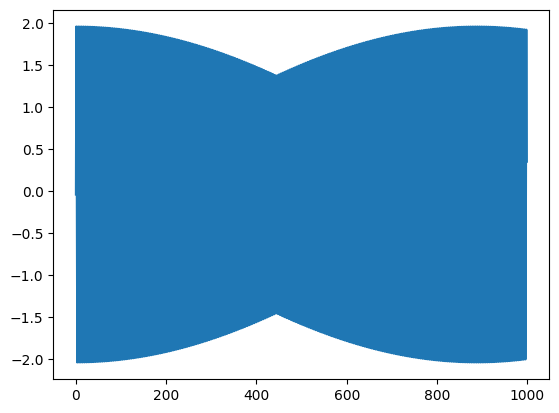

In [197]:
lim_inf = int(N/4 - 50)
lim_sup = int(N/4 + 50)

plt.plot(s_10db[:,0])